# Project Twitter Airline Sentiment

This project is sentiment analysis of major US airlines. The dataset are tweets from Twitter.

## Import the libraries, load dataset, print shape of data, data description. (5 Marks)

In [1]:
#presentation
import warnings
warnings.filterwarnings('ignore')

#basics
import re
import numpy as np                              
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

#natural language
import nltk                                 
from nltk.tokenize import word_tokenize 
from bs4 import BeautifulSoup                 
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer #LancasterStemmer,
nltk.download('wordnet')

#sklearn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#!pip install vaderSentiment

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\opc51\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Packages loaded. Now load data

In [2]:
originalData = pd.read_csv('tweets.csv')
originalData.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Data has been successfully loaded.

In [3]:
originalData.shape

(14640, 15)

The data contains 14,640 tweets! 

What are the columns?

In [4]:
originalData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Very few numeric columns. Mostly object types in the data.

In [5]:
originalData.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


tweet_id is an identity column and not relevant for numeric data.

We don't know for sure what the second and third columns above are. They may be the output from a classification exercise. 

The retweet count is how often the tweet has been retweeted. It appears that the tweets are rarely passed on. 

## Understand of data-columns: (5 Marks)

### Drop all other columns except “text” and “airline_sentiment”.

In [6]:
filteredData = originalData[["text","airline_sentiment"]]
filteredData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


The sentiment is how the tweet has been classified. 

The text in the first 5 tweets contains an @VirginAmerica. Are the tweets from a number of different airlines?  Will we need to use some form of regular expression to extract what airlines are being commented on?

In [7]:
checkAirlineNames = filteredData.iloc[[10500,10600],:]
checkAirlineNames.head()

,text,airline_sentiment
10500,@USAirways ...be found when he checks in. Now ...,negative
10600,@USAirways can you please post wait time-have ...,negative


We could well need to extract the airline from each tweet.

### Check shape of the data

In [8]:
filteredData.shape

(14640, 2)

### Show First 5 rows

In [9]:
filteredData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## Text pre-processing: Data preparation. (20 Marks)

### Html tag removal.

We will use beautiful soup. We will remove html from each element in the dataframe

In [10]:
for i, row in filteredData.iterrows():
    bs4 = BeautifulSoup(row["text"], "html.parser")
    filteredData.at[i,'text'] = bs4.get_text()
    
filteredData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


We have removed all HTML tags using bueatiful soup.

I don't believe we had any in the first place though :)

## remove the numbers

In [11]:
for i, row in filteredData.iterrows():
    filteredData.at[i,'text'] = re.sub(r'\d+','',row["text"])
    
filteredData.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


The number have been removed

### Remove special characters and punctuation

In [12]:
for i, row in filteredData.iterrows():
    filteredData.at[i,'text'] = re.sub('[^A-Za-z\s]+', '',row["text"])
    
filteredData.head()

,text,airline_sentiment
0,VirginAmerica What dhepburn said,neutral
1,VirginAmerica plus youve added commercials to ...,positive
2,VirginAmerica I didnt today Must mean I need t...,neutral
3,VirginAmerica its really aggressive to blast o...,negative
4,VirginAmerica and its a really big bad thing a...,negative


The special characters and punctuation removed. This includes removing the @ symbol. This may be a mistake. A good deal of information is conveyed on twitter using the @ symbol followed by a word.

### Convert to lower case

In [13]:
for i, row in filteredData.iterrows():
    filteredData.at[i,'text'] = row["text"].lower()
    
filteredData.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercials to ...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica its really aggressive to blast o...,negative
4,virginamerica and its a really big bad thing a...,negative


All text is now lower case

### Tokenization

In [14]:
for i, row in filteredData.iterrows():
    filteredData.at[i,'text'] = word_tokenize(row["text"])
    
filteredData.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, youve, added, commercial...",positive
2,"[virginamerica, i, didnt, today, must, mean, i...",neutral
3,"[virginamerica, its, really, aggressive, to, b...",negative
4,"[virginamerica, and, its, a, really, big, bad,...",negative


The data has been tokenised.

### Lemmatize or stemming

We will use lemma's in this case. We have the memory required and it is expected to provide greater accuracy than stemming

In [15]:
# function to find lemmas for each word in a list
def MakeNewWordList(wordlist):
    lemmatizer = WordNetLemmatizer()
    
    newwordlist = []
    
    for word in wordlist:
        newword = lemmatizer.lemmatize(word)
        newwordlist.append(newword)

    return newwordlist

In [16]:
#iiterate over all rows
for i, row in filteredData.iterrows():
    wordlist = row["text"]
    filteredData.at[i,'text'] = MakeNewWordList(wordlist)

filteredData.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, youve, added, commercial...",positive
2,"[virginamerica, i, didnt, today, must, mean, i...",neutral
3,"[virginamerica, it, really, aggressive, to, bl...",negative
4,"[virginamerica, and, it, a, really, big, bad, ...",negative


Lemmatisation has been completed.

### Put words back into the data frame

In [17]:
# function to convert a list to a string
def listToString(list):
    str1 = " "
    return (str1.join(list))

for i, row in filteredData.iterrows():
    filteredData.at[i,'text'] = listToString(row["text"])
    
filteredData.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercial to t...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica it really aggressive to blast ob...,negative
4,virginamerica and it a really big bad thing ab...,negative


The words are back in the data.

### First 5 rows of data

In [18]:
filteredData.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercial to t...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica it really aggressive to blast ob...,negative
4,virginamerica and it a really big bad thing ab...,negative


## Vectorisation

### use CountVector

In [19]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
count_v_features = vectorizer.fit_transform(filteredData['text'])

count_v_features = count_v_features.toarray()       

In [20]:
count_v_features.shape

(14640, 1000)

### use TfidVectorization

In [21]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
tfid_v_features = vectorizer.fit_transform(filteredData['text'])

tfid_v_features = tfid_v_features.toarray() 

In [22]:
tfid_v_features.shape

(14640, 1000)

## Fit and evaluate Model

In [23]:
filteredData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


We will need to make the airline_sentiment column categorical 

In [24]:
filteredData["airline_sentiment"].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

We will need to assign numerical values to each sentiment type.

We will use -1 for negative, 0 for neutral, +1 for positive

In [25]:
filteredData[filteredData["airline_sentiment"] == 'negative'] = 0
filteredData[filteredData["airline_sentiment"] == 'neutral'] = 1
filteredData[filteredData["airline_sentiment"] == 'positive'] = 2
filteredData["airline_sentiment"].unique()

array([1, 2, 0], dtype=object)

In [26]:
filteredData['airline_sentiment'] = filteredData['airline_sentiment'].astype('int')
filteredData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 171.7+ KB


The column "airline_sentiment" is now categorical and suitable for classification algorithyms.

#### Count Vector Modeling

In [27]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(count_v_features, filteredData["airline_sentiment"], test_size=0.3, random_state=42)

In [28]:
# Using Random Forest to build model
# Also calculating the cross validation score.

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, count_v_features, filteredData["airline_sentiment"], cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7104508196721311


We have achieved an accuracy of 70%

In [29]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

[[2599  144   71]
 [ 444  372   68]
 [ 226  113  355]]


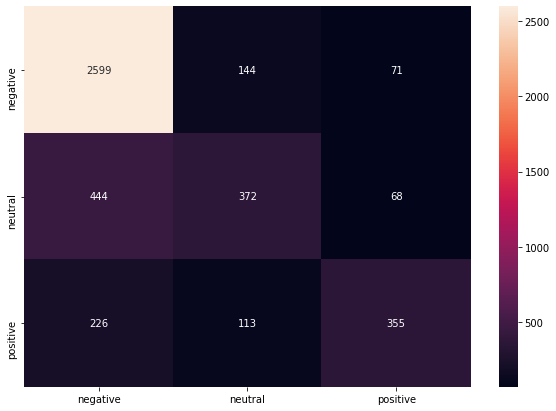

In [30]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["negative","neutral","positive"]],
                  columns = [i for i in ["negative","neutral","positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The model is strongest at picking up negative sentiment. This is to be expected because the data set has two times more  negative sentiments than the others combined.

In [31]:
filteredData.groupby("airline_sentiment").count()

,text
airline_sentiment,
0,9178
1,3099
2,2363


#### Tfid Vector Modeling

The code is almost identical we need to pass in "tfid_v_features" instead of "count_v_features".

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tfid_v_features, filteredData["airline_sentiment"], test_size=0.3, random_state=42)

In [33]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, tfid_v_features, filteredData["airline_sentiment"], cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7048497267759564


In [34]:
# Predict the result
result = forest.predict(X_test)

[[2587  171   56]
 [ 454  371   59]
 [ 241  108  345]]


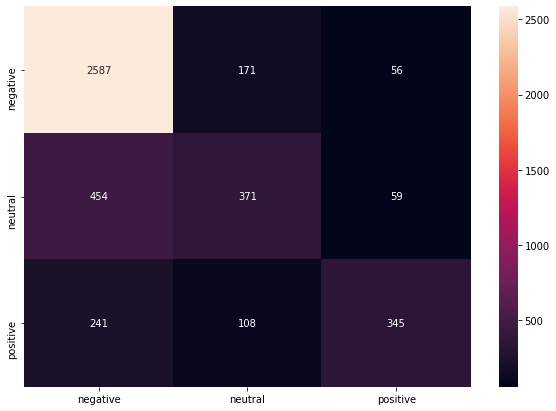

In [35]:
conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["negative","neutral","positive"]],#"012"],
                  columns = [i for i in ["negative","neutral","positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The model is strongest at picking up negative sentiment. This is to be expected because the data set has two times more  negative sentiments than the others combined.

# Summary 

In this case TfidfVectorizer and CountVectorizer both produced models with almost identical accuracies. One possible reason is that "stop word removal" was not done as part of the pre-processing. "Stop word removal" was not part of the marking scheme. Future explorations should consider removing stop words to try to increase the accuracy

Both models were better at picking up negative sentiment than positive sentiment. This is because the data set was highly skewed towards negative sentiment.

TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors.

CountVectorizer only counts the number of times a word appears in the document. TfidfVectorizer is based upon a combination of how often it appears and how often it is mentioned in each document. CountVectorizer has the problem of ignoring rare words that might be significant.

This model used lemmas instead of stemming. Lemmas were preferred due to the availablity of computing power and the importance of including morphological analysis.

Further models should try stemming incase it results in a better performance.

In this model "special characters" were removed at the pre-processing stage. This included removing the @ symbol which is used in tweets. As the @ symbol is of vital importance on twitter it may be advisable to include the @ symbol in future explorations of this model.